# CrateDB and Linear Regression

In this notebook, we import Twitter data from CrateDB as a Pandas dataframe and then fit a linear regression model on that data. The goal is to predict the number of followers a user has depending on the number of people they are following, using regression analysis.

In [1]:
import numpy as np
import pandas as pd 

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')
# you must manually install `crate` in the Anaconda environment, like so:
#
#     /anaconda3/bin/pip install crate

In [2]:
rcParams['axes.grid'] = True
rcParams['figure.figsize'] = 10,5

# Load the Data From CrateDB

In [3]:
limit = 100000
sql_query = """
    SELECT DISTINCT account_user['id'] AS id,
                    account_user['followers_count'] AS followers,
                    account_user['friends_count'] AS followees
               FROM tweets
              LIMIT {};
    """.format(limit)

# SQL query works out of the box with SQLAlchemy
try:
    # query CrateDB
    df_data = pd.read_sql(
        sql_query, 'crate://localhost:4200', index_col='id')
    # let's have a look at the first 5 rows
    display(df_data.head(5))
except Exception as error:
    print(error)
    print('CreatDB running and tweets imported?')
    


,followers,followees
id,,
4058133073,261,168
824728974886592513,472,346
908034526277971976,139,1502
1091477554416869376,57,52
881550387961933824,405,152


# Explore the Data

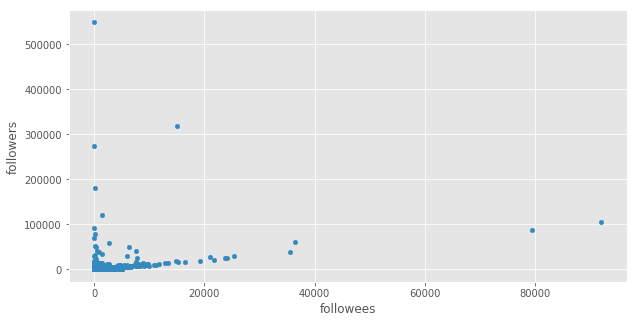

In [4]:
df_data.plot.scatter(x='followees', y='followers')
plt.show()

# Preprocess Data

In [5]:
# remove row if one value is zero, because log is -inf on zero
df_data = df_data.loc[~(df_data == 0).any(axis=1)] 

# apply log to followers and followees
df_data_transformed = df_data.apply(np.log10 )

# let's have a look at the first 5 rows after preprocessing data
display(df_data_transformed.head(5))

,followers,followees
id,,
4058133073,2.416641,2.225309
824728974886592513,2.673942,2.539076
908034526277971976,2.143015,3.176670
1091477554416869376,1.755875,1.716003
881550387961933824,2.607455,2.181844


# Plot the Processed Data 

[Text(0, 0.5, 'log(followers)'), Text(0.5, 0, 'log(followees)')]

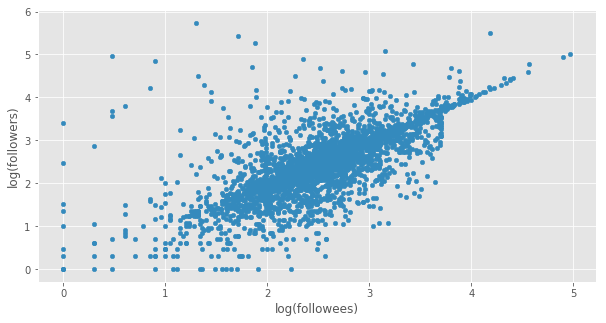

In [6]:
ax = df_data_transformed.plot.scatter(x='followees', y='followers')
ax.set(xlabel='log(followees)', ylabel='log(followers)')

# Split into training and testing data

In [7]:

#randomly split in train and test data
df_train, df_test = train_test_split(df_data_transformed, test_size=(1/3), random_state=42)

# Create a baseline reference

In [8]:
average_followers = df_train.followers.mean()
display('Average followers '+ str(average_followers))

bin_count = 5
binned_friends = pd.cut(df_train.followees, bin_count)
average_binned_followers = df_train[['followers']].groupby(binned_friends).mean()
display(average_binned_followers)

'Average followers 2.3789431947125252'

,followers
followees,
"(-0.00496, 0.993]",1.294223
"(0.993, 1.986]",1.610918
"(1.986, 2.979]",2.362340
"(2.979, 3.971]",3.161637
"(3.971, 4.964]",4.356598


# Evaluate baseline

In [9]:

# Always use average_followers
followers_pred = np.full(len(df_test.followers),average_followers)
# The root mean squared error in the log space
print("Root mean squared error: %.2f" 
      % np.sqrt(mean_squared_error(df_test.followers, followers_pred )))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(df_test.followers, followers_pred))

Root mean squared error: 0.79
Variance score: -0.01


 r2_score will give us some information about the goodness of the model fit, and it is a measure of the linear relationship between the input and the output. 1 would be perfect, while zero or even negative values would indicate a bad fit. In our case it is expected to get a value of 0.0. Since we always return the same value (average_followers), there is no relationship at all.


## Let's use the binned values 

In [10]:
min_value = average_binned_followers.index.min().left
max_value = average_binned_followers.index.max().right

In [11]:

# Use the binned average values 
followers_pred = average_binned_followers.loc[df_test.followees.clip(min_value, max_value)]
# The root mean squared error in the log space
print("Root mean squared error: %.2f"
      % np.sqrt(mean_squared_error(df_test.followers, followers_pred )))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(df_test.followers, followers_pred))

Root mean squared error: 0.66
Variance score: 0.29


With this simple optimization, we already can see an improvement of the RMSE value, as well as, a higher r2 value. 
Let's use these values as our base model. 

# Train the linear regression model 

In [12]:

# Create linear regression object
regr = LinearRegression()
# Train the model using the training set
regr.fit(df_train[['followees']], df_train.followers)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

# Evaluate the model 

In [13]:
# Make predictions using the testing set
followers_pred = regr.predict(df_test[['followees']])
# The root mean squared error in the log space
print("Root mean squared error: %.2f"
      % np.sqrt(mean_squared_error(df_test.followers, followers_pred)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(df_test.followers, followers_pred))

Root mean squared error: 0.62
Variance score: 0.39


### Compare the model

Let's compare the lineare regression model with our base line model. 

The RMSE value decreased by about 1/3, while the r2 value increased. These two values support our hypothesis that linear regression is a better model than our baseline model and we don't have to reject it. 

The following plot shows us the actual test data in blue and in red the predicted followers based on the friends of the test data. 

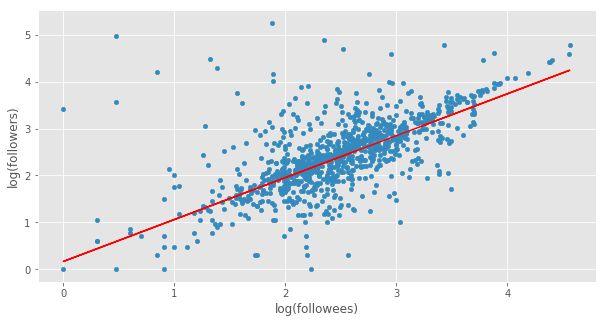

In [14]:
# Plot outputs
ax = df_test.plot.scatter(x='followees', y='followers')
ax.set(xlabel='log(followees)', ylabel='log(followers)')
plt.plot(df_test.followees, followers_pred, color='red')


# Get Original Values

Of course these values currently don't represent the actuall followers, because we previously preprocessed the data and scaled it with log. Let's scale them back to actually represent the original values again.


In [15]:

df_predicted = df_test[['followees']] # return it as a Datafram
df_predicted['predicted_followers'] = followers_pred
# rescale to represent the actuall friends and follower count
# return it as int not float 
df_predicted = df_predicted.apply(np.exp).astype(int)
df_predicted.head(5)


,followees,predicted_followers
id,,
252564115,14,12
2789628483,13,12
977495870651424768,11,10
964564652574363648,42,33
42646399,3,3


# Write back to CrateDB

Assuming the df_predicted dataframe would be of interesst we are going to write it back in a new CrateDB table. 

In [16]:
#promote id from index type back as column, so it shows up in the table
df_predicted_reset = df_predicted.reset_index() 
df_predicted_reset.to_sql('predicted_followers', 'crate://localhost', if_exists='append', index=False )